#                                       Accelerated seam carving

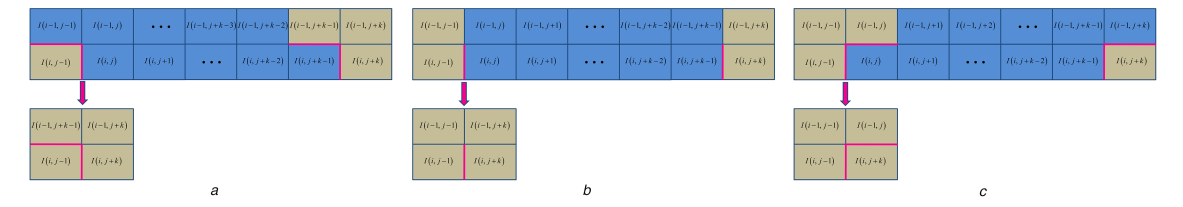

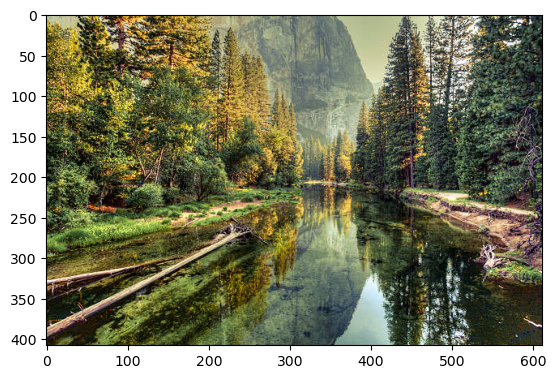

In [11]:
# potrebne biblioteke
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

# ucitavamo sliku
image = Image.open('assets/nature2.jpg')
img = np.array(image).astype(np.float32)
plt.imshow(image)

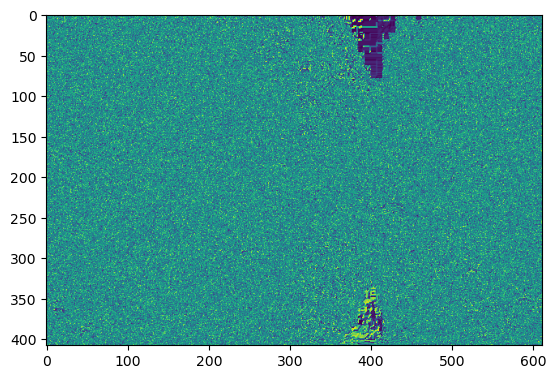

In [12]:
def energy_map(image):
    sx = ndimage.sobel(image, axis = 0, mode='constant')
    sy = ndimage.sobel(image, axis = 1, mode='constant')
    sobel = np.absolute(sx) + np.absolute(sy)
    energy = sobel.sum(axis = 2)
    return energy

X = energy_map(image)
plt.imshow(X)

In [13]:
def F_a(i, j, K, img):
    return np.linalg.norm(img[i, j + K] - img[i, j - 1]) + np.linalg.norm(img[i - 1, j + K - 1] - img[i, j - 1])

def F_b(i, j, K, img):
    return np.linalg.norm(img[i, j + K] - img[i, j - 1])

def F_c(i, j, K, img):
    return np.linalg.norm(img[i, j + K] - img[i, j - 1]) + np.linalg.norm(img[i - 1, j] - img[i, j + K])

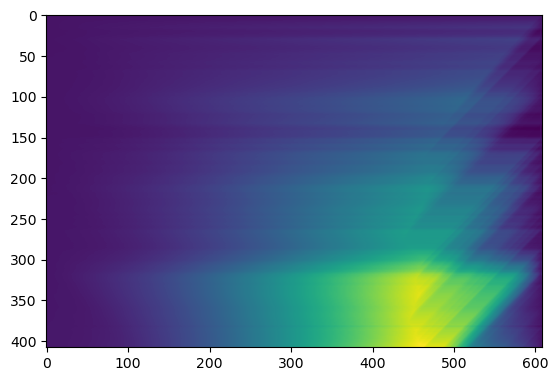

In [14]:
def matrix_M(img, K):
    rows = img.shape[0]
    cols = img.shape[1]

    E = energy_map(img)
    
    # matrica M ima isti broj redova kao i slika, ali ima K kolona manje
    # to je zato sto polje [i, j] matrice M predstavlja deo trake na vrsti i
    # kome je najlevlja tacka [i, j]
    M = np.zeros((rows, cols - K))

    e = 0
    
    # prvi red predstavlja ukupnu energiju svakog dela trake
    # ona se racuna kao zbir energija piksela koji ucestvuju
    
    for j in range(0, K):
        e += E[0][j]
    
    M[0, 0] = e
    e -= E[0][0]
    e += E[0][K]

    for j in range(1, cols - K - 1):
        M[0, j] = e
        e -= E[0][j - 1]
        e += E[0][j + K + 1]
        
    M[0, cols - K - 1] = e

    # u svakom narednom redu racunamo zbir energija piksela koji ucestvuju
    # i razmatramo sva tri (ili dva u slucaju prvog i poslednjeg) slucaja
    # i dodajemo njihove forward energije
    for i in range(1, rows):
        e = 0
        for j in range(0, K):
            e += E[i][j]

        M[i, 0] = e + min(M[i - 1, 0] + F_b(i, j, K, img), M[i - 1, 1] + F_c(i, j, K, img))
        e -= E[i][0]
        e += E[i][K]

        for j in range(1 , cols - K - 2):
            M[i, j] = e + min(min(M[i - 1, j - 1] + F_a(i, j, K, img), M[i - 1, j] + F_b(i, j, K, img)), M[i - 1, j + 1] + F_c(i, j, K, img))
            e -= E[i][j - 1]
            e += E[i][j + K]

            M[i, cols - K - 2] = e
            e -= E[i][cols - K - 2]
            e += E[i][cols - 1]

        M[i, cols - K - 1] = e + min(M[i - 1, j - 1] + F_a(i, j, K, img), M[i - 1, j] + F_b(i, j, K, img))

    return M

K = 3
M = matrix_M(img, K)
plt.imshow(M)

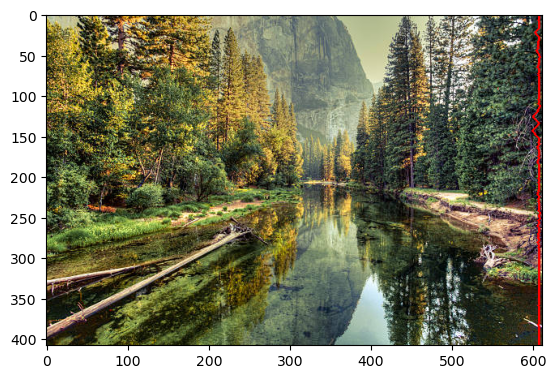

In [17]:
def batch_seam(img, K):
    rows = img.shape[0]
    cols = img.shape[1]

    M = matrix_M(img, K)

    ## trazimo minimum u poslednjem redu od M
    m = 0
    for j in range(1, cols - K):
        if M[rows - 1, j] < M[rows - 1, m]:
            m = j

    seam = np.zeros(rows).astype(int)

    seam[rows - 1] = m

    for i in reversed(range(rows - 1)):
        _min = seam[i + 1]
        if _min == cols - K - 1:
            seam[i] = (_min if (M[i, _min] < M[i, _min - 1]) else _min - 1)
        elif _min == 0:
            seam[i] = (_min if (M[i, _min] < M[i, _min + 1]) else _min + 1)
        else:
            x = min(M[i, _min - 1], min(M[i, _min], M[i, _min + 1]))
            if x == M[i, _min]:
                seam[i] = _min
            elif x == M[i, _min - 1]:
                seam[i] = _min - 1
            else:
                seam[i] = _min + 1

    return seam

first_seam = batch_seam(img, K)

# obojicemo traku u crveno
for i in range(img.shape[0]):
    for j in range(first_seam[i], first_seam[i] + K):
        img[i, j] = [255, 0, 0]

plt.imshow(img.astype(np.uint8))

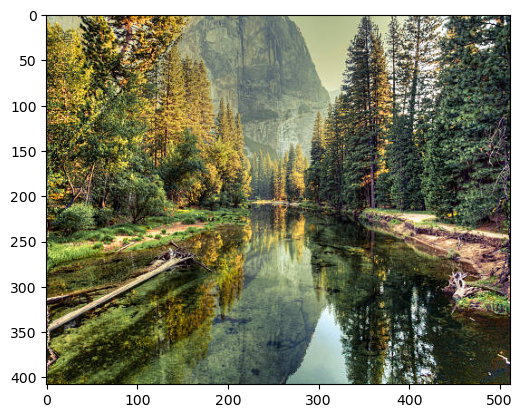

In [19]:
def seam_carving_vertical(img, K, target_width):
    rows = img.shape[0]
    cols = img.shape[1]
    tmp = img

    # brisemo dokle god nismo postigli zeljenu sirinu
    # ukoliko je K vece od razlike sirina, menjamo ga
    while cols > target_width:
        if cols - target_width < K:
            K = cols - target_width

        seam = batch_seam(tmp, K)

        ## brisemo traku sa slike
        new_img = np.zeros((rows, cols - K, 3), np.float32)
        for i in range(rows):
            for j in range(seam[i]):
                new_img[i, j] = tmp[i, j]

            for j in range(seam[i], cols - K):
                new_img[i, j] = tmp[i, j + K]

        tmp = new_img
        cols = tmp.shape[1]
        
    return new_img

image = Image.open('assets/nature2.jpg')
img = np.array(image).astype(np.float32)
img = seam_carving_vertical(img, K, img.shape[1] - 100)
plt.imshow(img.astype(np.uint8))

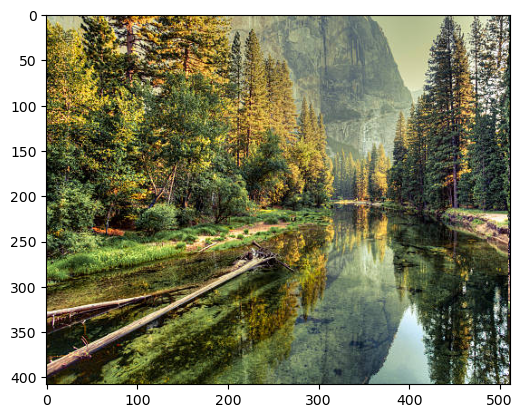

In [20]:
K = 5
image = Image.open('assets/nature2.jpg')
img = np.array(image).astype(np.float32)
img = seam_carving_vertical(img, K, img.shape[1] - 100)
plt.imshow(img.astype(np.uint8))

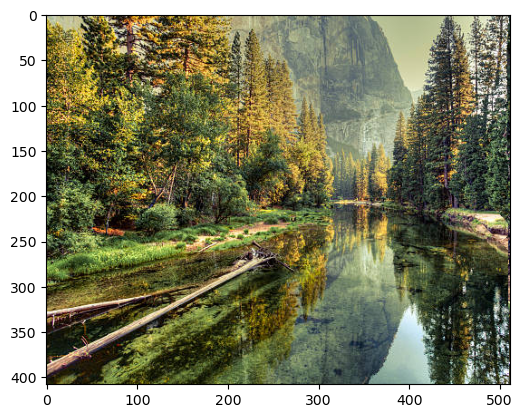

In [21]:
K = 10
image = Image.open('assets/nature2.jpg')
img = np.array(image).astype(np.float32)
img = seam_carving_vertical(img, K, img.shape[1] - 100)
plt.imshow(img.astype(np.uint8))

# #                                Adaptibilnost koraka

In [22]:
# zbog funkcije print
import sys
stdout = sys.stdout
sys.stdout = stdout


10
10
10
9
8
7
6
5
4
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


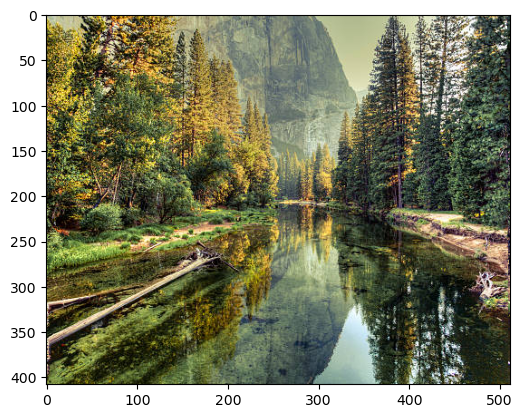

In [23]:
def seam_carving_vertical_adaptible(img, K, target_width):
    rows = img.shape[0]
    cols = img.shape[1]
    tmp = img
    
    E = energy_map(img)
    
    E1 = np.average(E)
    E2 = E1
    # brisemo dokle god nismo postigli zeljenu sirinu
    # ukoliko je K vece od razlike sirina, menjamo ga
    while cols > target_width:
        # menjamo korak ukoliko se energija smanjila
        if E2 < E1 and K >= 2:
            K -= 1
            
        if cols - target_width < K:
            K = cols - target_width
            
        print(K)
        seam = batch_seam(tmp, K)

        ## brisemo traku sa slike
        new_img = np.zeros((rows, cols - K, 3), np.float32)
        for i in range(rows):
            for j in range(seam[i]):
                new_img[i, j] = tmp[i, j]

            for j in range(seam[i], cols - K):
                new_img[i, j] = tmp[i, j + K]

        tmp = new_img
        rows = tmp.shape[0]
        cols = tmp.shape[1]
        
        E = energy_map(tmp)
        E2 = np.average(E)
        
    return new_img

K = 10
image = Image.open('assets/nature2.jpg')
img = np.array(image).astype(np.float32)
img = seam_carving_vertical_adaptible(img, K, img.shape[1] - 100)
plt.imshow(img.astype(np.uint8))